- Tester tous les modèles sans gridsearchCV (1 ou 2 par grandes familles)
- Selectionner les meilleurs modèles car ce ne sont pas les hyperparamètres qui changent beaucoup. 
- Tester les valeurs extrêmes des hyperparamètres pour savoir dans quel direction aller. 
- Ensuite on peut choisir le meilleur modèle et faire évoluer les hyperparamètres. 
- Un fois que le gridsearchCV est terminé, on n'en fait plus et on reste sur les valeurs selectionnées. 
- Il faut trouver trouver des modèles avec un features importance globale et locale (pas de blackbox)

Pour le déséquilibre, regarder les modèles qui intègrent les déséquilibres. Ou alors, créer des faux clients qui n'auraient pas et de crétit (regarder SMOTE) Data Augmentation

DataDRIFT
Introduction de la notion de temps en se plaçant dans le passé. Se mettre comme si on était en 2022 par exemple. 

In [2]:
# Import des bibliothèques nécessaires
import os
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [4]:
# Configuration de l'URI MLFlow
os.environ["MLFLOW_TRACKING_URI"] = "http://127.0.0.1:5000"

In [5]:
# Charger les données
start_time = time.time()
app_train = pd.read_csv("Base De Donnée Prétraitée.csv")
print(f"Temps de chargement des données : {time.time() - start_time:.2f} secondes")

Temps de chargement des données : 2.79 secondes


In [6]:
# Séparer les caractéristiques et la cible
train_labels = app_train['TARGET']
train = app_train.drop(columns=['TARGET'])

In [7]:
# Imputation et Normalisation des Données
imputer = SimpleImputer(strategy='median')
scaler = MinMaxScaler(feature_range=(0, 1))

In [8]:
# Imputer et normaliser les données
train = imputer.fit_transform(train)
train = scaler.fit_transform(train)

In [9]:
# Séparer les données en entraînement et validation
X_train, X_test, y_train, y_test = train_test_split(train, train_labels, test_size=0.3, random_state=0)

In [10]:
# Fonction pour tracer et loguer la matrice de confusion
def plot_and_log_confusion_matrix(model_name, y_test, y_pred):
    # Calcul de la matrice de confusion
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Non-défaillant', 'Défaillant'], yticklabels=['Non-défaillant', 'Défaillant'])
    plt.xlabel('Prédictions')
    plt.ylabel('Réel')
    plt.title(f'Matrice de Confusion - {model_name}')
    
    # Enregistrement de la figure dans MLFlow
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.show()

In [11]:
# Définition de la fonction d'évaluation et de logging avec MLFlow, incluant les temps d'exécution
def evaluate_and_log_model(model, model_name, model_type):
    with mlflow.start_run():
        # Mesurer le temps d'entraînement du modèle
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        print(f"Temps d'entraînement pour {model_name}: {training_time:.2f} secondes")
        mlflow.log_metric("training_time", training_time)

        # Mesurer le temps de prédiction
        start_time = time.time()
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
        prediction_time = time.time() - start_time
        print(f"Temps de prédiction pour {model_name}: {prediction_time:.2f} secondes")
        mlflow.log_metric("prediction_time", prediction_time)

        # Évaluation des performances
        auc = roc_auc_score(y_test, y_proba)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Matrice de confusion et calcul du coût métier
        conf_matrix = confusion_matrix(y_test, y_pred)
        fp = conf_matrix[0][1]
        fn = conf_matrix[1][0]
        cost = fp + 10 * fn  # Coût métier, avec FN pondéré 10 fois plus que FP

        # Enregistrement des métriques et paramètres dans MLFlow
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Cost", cost)
        mlflow.log_param("model_type", model_type)
        
        # Enregistrement du modèle
        mlflow.sklearn.log_model(model, model_name)
        
        # Affichage des résultats
        print(f"{model_name} - AUC: {auc}")
        print(f"{model_name} - Accuracy: {accuracy}")
        print(f"{model_name} - Cost: {cost}")
        
        # Tracer et loguer la matrice de confusion
        plot_and_log_confusion_matrix(model_name, y_test, y_pred)

In [ ]:
# Liste des modèles à tester
models = [
    (DecisionTreeClassifier(class_weight='balanced', random_state=0), "DecisionTreeClassifier", "Decision Tree"),
    (RandomForestClassifier(class_weight='balanced', random_state=0), "RandomForestClassifier", "Ensemble - Random Forest"),
    (ExtraTreesClassifier(class_weight='balanced', random_state=0), "ExtraTreesClassifier", "Ensemble - Extra Trees"),
    (GradientBoostingClassifier(random_state=0), "GradientBoostingClassifier", "Ensemble - Boosting"),
    (XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0), "XGBClassifier", "Boosting - XGBoost"),
    (LGBMClassifier(random_state=0), "LGBMClassifier", "Boosting - LightGBM"),
    (CatBoostClassifier(verbose=0, random_state=0), "CatBoostClassifier", "Boosting - CatBoost")
]

In [ ]:
# Exécuter chaque modèle avec une barre de progression
for model, model_name, model_type in tqdm(models, desc="Évaluation des modèles"):
    print(f"\nÉvaluation du modèle : {model_name}")
    evaluate_and_log_model(model, model_name, model_type)

# Boosting - LightGBM

In [12]:
# Paramètres de la grille pour le GridSearchCV
param_grid = {
    'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200]
}

In [13]:
# Initialisation du modèle LightGBM
lgbm = LGBMClassifier(class_weight='balanced', random_state=0)
model_type = 'Boosting - LightGBM'
# Configuration de GridSearchCV
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LightGBM] [Info] Number of positive: 17485, number of negative: 197772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12873
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Temps de GridSearchCV : 282.24 secondes
[LightGBM] [Info] Number of positive: 17485, number of negative: 197772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12873
[Lig

2024/11/03 11:13:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Meilleurs paramètres : {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 31}
AUC : 0.7645017263499618
Accuracy : 0.7109176837860689
Cost : 48089


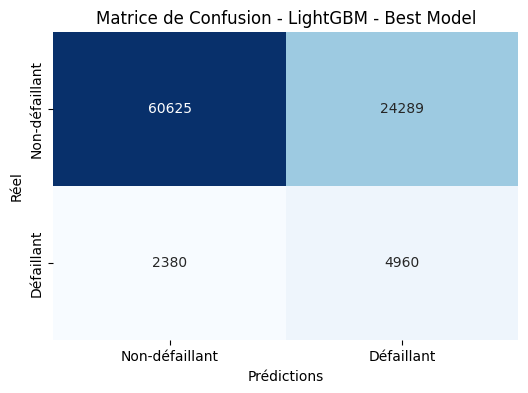

2024/11/03 11:13:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run fun-seal-899 at: http://127.0.0.1:5000/#/experiments/0/runs/fc3c0569822a40978e39e3bd0101ce9e.
2024/11/03 11:13:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


[LightGBM] [Info] Number of positive: 11657, number of negative: 131848
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.203384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13014
[LightGBM] [Info] Number of data points in the train set: 143505, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 11656, number of negative: 131848
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13001
[LightGBM] [Info] Number of data points in the train set: 143504, number of used features: 236
[LightGBM] [

In [15]:
# Démarrer une expérimentation MLFlow
with mlflow.start_run():
    # Mesurer le temps de recherche de la grille
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    grid_search_time = time.time() - start_time
    print(f"Temps de GridSearchCV : {grid_search_time:.2f} secondes")
    mlflow.log_metric("grid_search_time", grid_search_time)
    
    # Enregistrer les meilleurs paramètres trouvés
    best_params = grid_search.best_params_
    for param, value in best_params.items():
        mlflow.log_param(param, value)
    
    # Meilleur modèle obtenu par GridSearchCV
    best_model = grid_search.best_estimator_

    # Entraîner le meilleur modèle sur l’ensemble d’entraînement complet
    start_time = time.time()
    best_model.fit(X_train, y_train)
    training_time = time.time() - start_time
    mlflow.log_metric("training_time", training_time)

    # Prédictions et évaluation sur l’ensemble de test
    start_time = time.time()
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]
    prediction_time = time.time() - start_time
    mlflow.log_metric("prediction_time", prediction_time)
    
    # Calcul des métriques
    auc = roc_auc_score(y_test, y_proba)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    fp = conf_matrix[0][1]
    fn = conf_matrix[1][0]
    cost = fp + 10 * fn  # Coût métier

    # Enregistrement des métriques dans MLFlow
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("Accuracy", accuracy)
    mlflow.log_metric("Cost", cost)
    mlflow.log_param("model_type", model_type)
    
    # Enregistrement du modèle dans MLFlow
    mlflow.sklearn.log_model(best_model, "best_lightgbm_model")

    # Affichage des résultats
    print(f"Meilleurs paramètres : {best_params}")
    print(f"AUC : {auc}")
    print(f"Accuracy : {accuracy}")
    print(f"Cost : {cost}")

    # Tracer et loguer la matrice de confusion
    plot_and_log_confusion_matrix("LightGBM - Best Model", y_test, y_pred)

# Feature Importance

## Feature Importance Globale

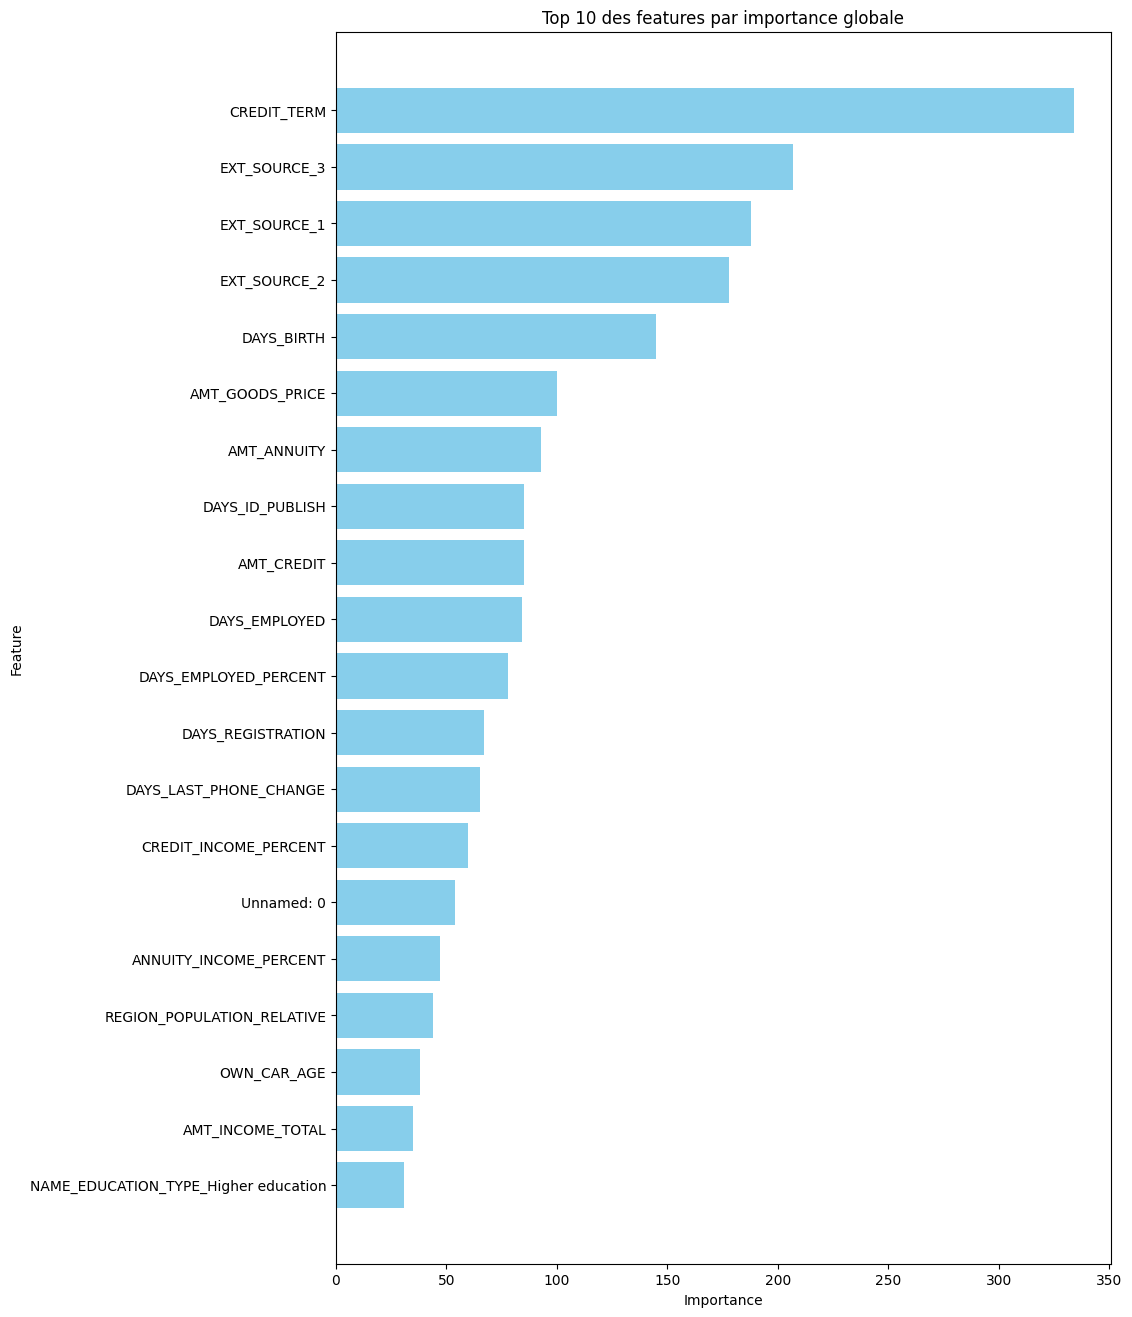

In [21]:
# Récupérer l'importance des features
feature_importances = best_model.feature_importances_
feature_names = app_train.drop(columns=['TARGET']).columns

# Créer un DataFrame pour organiser les importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Afficher les 10 features les plus importantes
plt.figure(figsize=(10, 16))
plt.barh(importance_df['Feature'].head(20), importance_df['Importance'].head(20), color='skyblue')
plt.gca().invert_yaxis()
plt.title("Top 10 des features par importance globale")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

## Feature Importance Local

In [ ]:
import shap

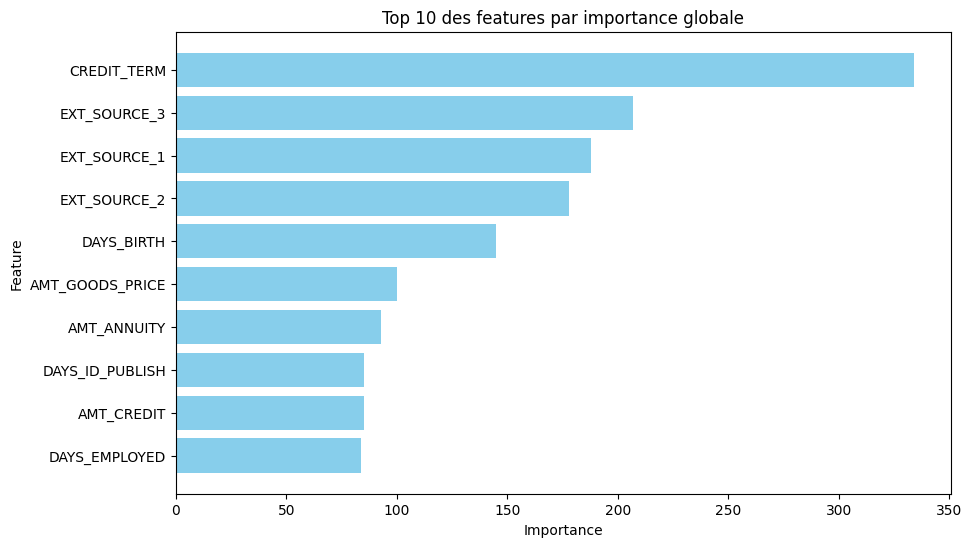

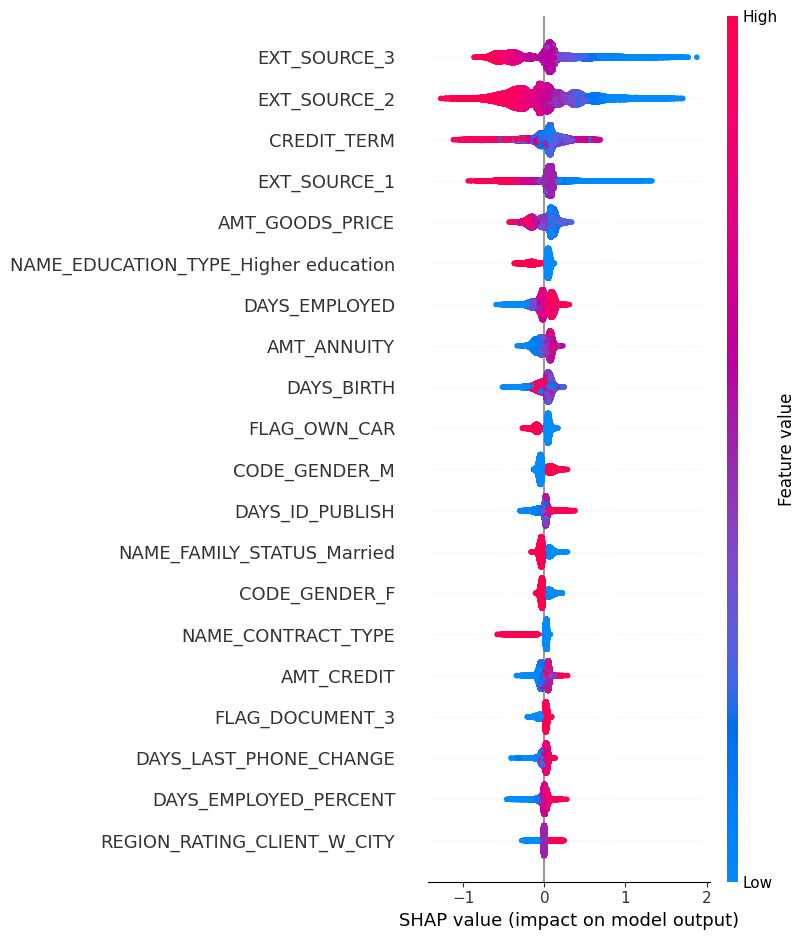

In [29]:
# Analyse de l'importance globale avec feature_importances_
feature_importances = best_model.feature_importances_
feature_names = app_train.drop(columns=['TARGET']).columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualiser les 10 principales features par importance globale
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.gca().invert_yaxis()
plt.title("Top 10 des features par importance globale")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Initialisation de SHAP pour LightGBM
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_test)  # Créer un objet Explanation

# Importance locale : force plot pour un client spécifique
client_index = 0  # Exemple : premier client dans le jeu de test

# Utilisation de shap.force_plot avec l'objet Explanation
shap.initjs()
shap.force_plot(shap_values[client_index])

# Importance globale : summary plot de SHAP
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

In [32]:
import pickle

# Après avoir obtenu le meilleur modèle avec GridSearchCV
best_model = grid_search.best_estimator_

# Entraînement du modèle sur l'ensemble complet (si nécessaire)
best_model.fit(X_train, y_train)

# Exporter le modèle entraîné
with open("best_lightgbm_model.pkl", "wb") as model_file:
    pickle.dump(best_model, model_file)

print("Modèle LightGBM exporté avec succès sous 'best_lightgbm_model.pkl'")

[LightGBM] [Info] Number of positive: 17485, number of negative: 197772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12873
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Modèle LightGBM exporté avec succès sous 'best_lightgbm_model.pkl'


In [30]:
import streamlit as st
import pickle

In [33]:
# Charger le modèle entraîné
# Assurez-vous d'avoir sauvegardé le modèle préalablement avec pickle.
with open("best_lightgbm_model.pkl", "rb") as model_file:
    model = pickle.load(model_file)

# Définir les cinq variables les plus importantes
important_features = ["EXT_SOURCE_3", "EXT_SOURCE_2", "CREDIT_TERM", "EXT_SOURCE_1", "AMT_GOODS_PRICE"]

# Explications de chaque feature pour faciliter la saisie par l'utilisateur
feature_descriptions = {
    "EXT_SOURCE_3": "Score externe 3 (Source de solvabilité externe)",
    "EXT_SOURCE_2": "Score externe 2 (Source de solvabilité externe)",
    "CREDIT_TERM": "Durée du crédit (en mois)",
    "EXT_SOURCE_1": "Score externe 1 (Source de solvabilité externe)",
    "AMT_GOODS_PRICE": "Montant du bien financé (prix en devises locales)"
}

# Fonction pour faire la prédiction et calculer les explications SHAP
def predict_and_explain(model, data):
    # Faire la prédiction
    prediction_proba = model.predict_proba(data)[:, 1][0]
    prediction = "Accordé" if prediction_proba < 0.5 else "Refusé"
    
    # Créer un explainer SHAP pour le modèle
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(data)
    
    return prediction, prediction_proba, shap_values

# Configuration de l'interface Streamlit
st.title("Évaluation de la Demande de Prêt")
st.write("Entrez les informations du client pour évaluer la probabilité d'acceptation de la demande de prêt.")

# Formulaire pour saisir les valeurs des features
user_input = {}
for feature in important_features:
    user_input[feature] = st.number_input(f"{feature} - {feature_descriptions[feature]}")

# Préparer les données pour le modèle
data = pd.DataFrame([user_input])

# Lorsque l'utilisateur clique sur le bouton, faire la prédiction
if st.button("Évaluer la demande de prêt"):
    prediction, prediction_proba, shap_values = predict_and_explain(model, data)
    
    # Afficher les résultats
    st.subheader("Résultat de la Prédiction")
    st.write(f"Probabilité de défaut : {prediction_proba:.2f}")
    st.write(f"Décision : **{prediction}**")

    # Explication avec SHAP force plot
    st.subheader("Explication de la Prédiction (Importance des Variables)")
    shap.initjs()
    st_shap = shap.force_plot(shap_values[1][0], data, feature_names=important_features)
    st.pyplot(st_shap)

2024-11-03 12:43:52.265 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-03 12:43:52.306 
  command:

    streamlit run /opt/anaconda3/envs/DS_PROJET_7/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-11-03 12:43:52.307 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-03 12:43:52.307 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-03 12:43:52.308 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-03 12:43:52.308 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-03 12:43:52.309 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-03 12:43:52.309 Threa

In [35]:
pip show streamlit

Name: streamlit
Version: 1.39.0
Summary: A faster way to build and share data apps
Home-page: https://streamlit.io
Author: Snowflake Inc
Author-email: hello@streamlit.io
License: Apache License 2.0
Location: /opt/anaconda3/envs/DS_PROJET_7/lib/python3.11/site-packages
Requires: altair, blinker, cachetools, click, gitpython, numpy, packaging, pandas, pillow, protobuf, pyarrow, pydeck, requests, rich, tenacity, toml, tornado, typing-extensions
Required-by: 
Note: you may need to restart the kernel to use updated packages.


# Réetraineemnt du modèle avec 5 variables

In [49]:
import pickle
from lightgbm import LGBMClassifier
import pandas as pd

# Charger les données d'entraînement
app_train = pd.read_csv("Base De Donnée Prétraitée.csv")

# Sélectionner les 5 features les plus importantes et la cible
important_features = ["EXT_SOURCE_3", "EXT_SOURCE_2", "CREDIT_TERM", "EXT_SOURCE_1", "AMT_GOODS_PRICE"]
X_train = app_train[important_features]
y_train = app_train['TARGET']

# Entraîner le modèle LightGBM sur les 5 features
model = LGBMClassifier(class_weight='balanced', random_state=0)
model.fit(X_train, y_train)

# Sauvegarder le modèle entraîné
with open("lightgbm_model_5_features.pkl", "wb") as model_file:
    pickle.dump(model, model_file)

print("Modèle entraîné sur 5 features sauvegardé avec succès.")


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1271
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Modèle entraîné sur 5 features sauvegardé avec succès.


In [53]:
app_train[["EXT_SOURCE_3","EXT_SOURCE_2","CREDIT_TERM","EXT_SOURCE_1","AMT_GOODS_PRICE","TARGET"]].loc[app_train["TARGET"]==0].head(30)

,EXT_SOURCE_3,EXT_SOURCE_2,CREDIT_TERM,EXT_SOURCE_1,AMT_GOODS_PRICE,TARGET
1,NaN,0.622246,0.027598,0.311267,1129500.0,0
2,0.729567,0.555912,0.050000,NaN,135000.0,0
3,NaN,0.650442,0.094941,NaN,297000.0,0
4,NaN,0.322738,0.042623,NaN,513000.0,0
5,0.621226,0.354225,0.056101,NaN,454500.0,0
6,0.492060,0.724000,0.026463,0.774761,1395000.0,0
7,0.540654,0.714279,0.027500,NaN,1530000.0,0
8,0.751724,0.205747,0.033176,0.587334,913500.0,0
9,NaN,0.746644,0.050000,NaN,405000.0,0
10,0.363945,0.651862,0.032455,0.319760,652500.0,0
